In [1]:
# Import data science environment.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy
import sklearn
from sklearn import linear_model
from sklearn import neighbors
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format
sns.set_style('white')

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(
    action='ignore',
    module='scipy',
    message='internal gelsd'
)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Load and preview the data file.
housing = pd.read_csv('Melbourne_housing_FULL.csv')
housing.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,nan,SS,Jellis,3/09/2016,2.500,3067.000,...,1.000,1.000,126.000,nan,nan,Yarra City Council,-37.801,144.996,Northern Metropolitan,4019.000
1,Abbotsford,85 Turner St,2,h,1480000.000,S,Biggin,3/12/2016,2.500,3067.000,...,1.000,1.000,202.000,nan,nan,Yarra City Council,-37.800,144.998,Northern Metropolitan,4019.000
2,Abbotsford,25 Bloomburg St,2,h,1035000.000,S,Biggin,4/02/2016,2.500,3067.000,...,1.000,0.000,156.000,79.000,1900.000,Yarra City Council,-37.808,144.993,Northern Metropolitan,4019.000
3,Abbotsford,18/659 Victoria St,3,u,nan,VB,Rounds,4/02/2016,2.500,3067.000,...,2.000,1.000,0.000,nan,nan,Yarra City Council,-37.811,145.012,Northern Metropolitan,4019.000
4,Abbotsford,5 Charles St,3,h,1465000.000,SP,Biggin,4/03/2017,2.500,3067.000,...,2.000,0.000,134.000,150.000,1900.000,Yarra City Council,-37.809,144.994,Northern Metropolitan,4019.000


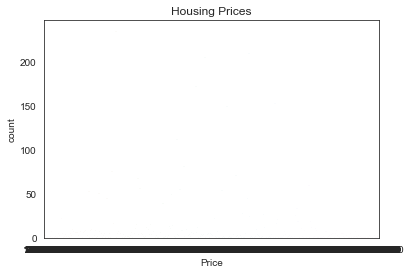

600000.000     235
1100000.000    235
650000.000     219
800000.000     217
1300000.000    210
1000000.000    205
1200000.000    204
700000.000     197
750000.000     194
900000.000     191
850000.000     176
950000.000     172
1250000.000    158
1500000.000    153
500000.000     153
1400000.000    150
1150000.000    149
550000.000     141
1050000.000    139
780000.000     136
770000.000     131
720000.000     128
1350000.000    125
730000.000     124
630000.000     124
580000.000     123
620000.000     123
680000.000     122
820000.000     120
640000.000     120
              ... 
319000.000       1
4240000.000      1
499500.000       1
800500.000       1
682100.000       1
2033000.000      1
1102200.000      1
253000.000       1
2168000.000      1
332500.000       1
280500.000       1
645400.000       1
549800.000       1
3510000.000      1
746500.000       1
1538000.000      1
1231010.000      1
550055.000       1
373333.000       1
1142500.000      1
527500.000       1
503500.000  

In [3]:
# View value counts.
sns.countplot('Price', data=housing)
plt.title('Housing Prices')
plt.show()
pd.value_counts(housing['Price'])

The countplot seems useless, probably due to the enormous number of individual prices and the relatively few houses that correlate with each. Let's see how many unique values we have, as we may not need to worry about the class imbalance.

In [4]:
housing.nunique()

Suburb             351
Address          34009
Rooms               12
Type                 3
Price             2871
Method               9
SellerG            388
Date                78
Distance           215
Postcode           211
Bedroom2            15
Bathroom            11
Car                 15
Landsize          1684
BuildingArea       740
YearBuilt          160
CouncilArea         33
Lattitude        13402
Longtitude       14524
Regionname           8
Propertycount      342
dtype: int64

With 2,871 unique values for Price, it's no wonder I couldn't get a decent visualization. Let's take care of some column names that could be spelled better.

In [5]:
# Change column name misspellings.
housing.rename({'Landsize': 'LandSize', 'Lattitude': 'Latitude', 'Longtitude': 'Longitude',
                        'Propertycount': 'PropertyCount'}, axis='columns', inplace=True)

In [6]:
# Check data types.
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34857 entries, 0 to 34856
Data columns (total 21 columns):
Suburb           34857 non-null object
Address          34857 non-null object
Rooms            34857 non-null int64
Type             34857 non-null object
Price            27247 non-null float64
Method           34857 non-null object
SellerG          34857 non-null object
Date             34857 non-null object
Distance         34856 non-null float64
Postcode         34856 non-null float64
Bedroom2         26640 non-null float64
Bathroom         26631 non-null float64
Car              26129 non-null float64
LandSize         23047 non-null float64
BuildingArea     13742 non-null float64
YearBuilt        15551 non-null float64
CouncilArea      34854 non-null object
Latitude         26881 non-null float64
Longitude        26881 non-null float64
Regionname       34854 non-null object
PropertyCount    34854 non-null float64
dtypes: float64(12), int64(1), object(8)
memory usage: 5.6+ M

It seems that the dtypes make sense except 'Date' which should be a datetime, not object.

In [7]:
# Converting Date column to a datetime object.
housing['Date'] = pd.to_datetime(housing['Date'])
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34857 entries, 0 to 34856
Data columns (total 21 columns):
Suburb           34857 non-null object
Address          34857 non-null object
Rooms            34857 non-null int64
Type             34857 non-null object
Price            27247 non-null float64
Method           34857 non-null object
SellerG          34857 non-null object
Date             34857 non-null datetime64[ns]
Distance         34856 non-null float64
Postcode         34856 non-null float64
Bedroom2         26640 non-null float64
Bathroom         26631 non-null float64
Car              26129 non-null float64
LandSize         23047 non-null float64
BuildingArea     13742 non-null float64
YearBuilt        15551 non-null float64
CouncilArea      34854 non-null object
Latitude         26881 non-null float64
Longitude        26881 non-null float64
Regionname       34854 non-null object
PropertyCount    34854 non-null float64
dtypes: datetime64[ns](1), float64(12), int64(1), obj

There are some extremely varied counts. I think we may have a lot of null values in this dataset. Let's see.

In [8]:
housing.isnull().sum()

Suburb               0
Address              0
Rooms                0
Type                 0
Price             7610
Method               0
SellerG              0
Date                 0
Distance             1
Postcode             1
Bedroom2          8217
Bathroom          8226
Car               8728
LandSize         11810
BuildingArea     21115
YearBuilt        19306
CouncilArea          3
Latitude          7976
Longitude         7976
Regionname           3
PropertyCount        3
dtype: int64

There are a lot of null values that I will need to address. The first thing I notice is that 7,610 rows are missing a price. These rows are useless. We cannot impute values for the price, or else it will affect the integrity of our model. We need to drop these rows.

In [9]:
housing.dropna(subset=['Price'], inplace=True)
housing.isnull().sum()

Suburb               0
Address              0
Rooms                0
Type                 0
Price                0
Method               0
SellerG              0
Date                 0
Distance             1
Postcode             1
Bedroom2          6441
Bathroom          6447
Car               6824
LandSize          9265
BuildingArea     16591
YearBuilt        15163
CouncilArea          3
Latitude          6254
Longitude         6254
Regionname           3
PropertyCount        3
dtype: int64

In [10]:
housing.fillna(housing.median(), inplace=True)
housing.isnull().sum()

Suburb           0
Address          0
Rooms            0
Type             0
Price            0
Method           0
SellerG          0
Date             0
Distance         0
Postcode         0
Bedroom2         0
Bathroom         0
Car              0
LandSize         0
BuildingArea     0
YearBuilt        0
CouncilArea      3
Latitude         0
Longitude        0
Regionname       3
PropertyCount    0
dtype: int64

In [11]:
# Still three values in 'CouncilArea' and 'Regionname' columns.  Let's find where they are.
print(housing[housing['CouncilArea'].isnull()]['CouncilArea'])
print(housing[housing['Regionname'].isnull()]['Regionname'])

18523    NaN
26888    NaN
29483    NaN
Name: CouncilArea, dtype: object
18523    NaN
26888    NaN
29483    NaN
Name: Regionname, dtype: object


In [12]:
# Let's take a look at the first null row.
housing.loc[18523]

Suburb                     Footscray
Address             2/16 Stafford St
Rooms                              2
Type                               u
Price                     710000.000
Method                             S
SellerG                          Jas
Date             2017-07-15 00:00:00
Distance                       5.100
Postcode                    3011.000
Bedroom2                       3.000
Bathroom                       1.000
Car                            2.000
LandSize                     512.000
BuildingArea                 133.000
YearBuilt                   1970.000
CouncilArea                      NaN
Latitude                     -37.800
Longitude                    145.003
Regionname                       NaN
PropertyCount               6567.000
Name: 18523, dtype: object

In [13]:
# Let's see if we can find the missing data by looking at other houses in that Postcode.
housing[housing['Postcode'] == 3011]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,LandSize,BuildingArea,YearBuilt,CouncilArea,Latitude,Longitude,Regionname,PropertyCount
4377,Footscray,4/33 Ballarat Rd,3,t,585000.000,S,Nelson,2016-03-09,6.400,3011.000,...,1.000,1.000,259.000,133.000,1970.000,Maribyrnong City Council,-37.795,144.906,Western Metropolitan,7570.000
4378,Footscray,202/51 Gordon St,1,u,85000.000,PI,Burnham,2016-03-09,6.400,3011.000,...,1.000,0.000,0.000,133.000,2007.000,Maribyrnong City Council,-37.791,144.890,Western Metropolitan,7570.000
4379,Footscray,4 Adelaide St,4,h,1225000.000,SP,Nelson,2016-03-12,6.400,3011.000,...,2.000,1.000,319.000,130.000,1915.000,Maribyrnong City Council,-37.794,144.887,Western Metropolitan,7570.000
4380,Footscray,11/44 Everard St,2,u,431000.000,SP,Jas,2016-03-12,6.400,3011.000,...,1.000,1.000,0.000,133.000,1970.000,Maribyrnong City Council,-37.796,144.885,Western Metropolitan,7570.000
4381,Footscray,9 Lynch St,3,h,1003000.000,S,Naison,2016-03-12,6.400,3011.000,...,1.000,1.000,292.000,98.000,1900.000,Maribyrnong City Council,-37.797,144.905,Western Metropolitan,7570.000
4382,Footscray,25 Southampton St,3,h,840000.000,S,Sweeney,2016-03-12,6.400,3011.000,...,1.000,0.000,164.000,93.000,1900.000,Maribyrnong City Council,-37.796,144.886,Western Metropolitan,7570.000
4383,Footscray,37 Stirling St,3,h,1362000.000,S,Village,2016-03-12,6.400,3011.000,...,2.000,0.000,497.000,156.000,1890.000,Maribyrnong City Council,-37.796,144.902,Western Metropolitan,7570.000
4384,Footscray,58 Wolverhampton St,4,h,977000.000,S,Village,2016-03-12,6.400,3011.000,...,2.000,1.000,154.000,161.000,2007.000,Maribyrnong City Council,-37.798,144.891,Western Metropolitan,7570.000
4385,Footscray,2/3 Eldridge St,1,u,216000.000,S,Sweeney,2016-04-02,6.400,3011.000,...,1.000,1.000,0.000,50.000,1970.000,Maribyrnong City Council,-37.791,144.892,Western Metropolitan,7570.000
4386,Footscray,8 Buckingham St,3,h,876000.000,S,Jas,2017-04-03,6.400,3011.000,...,2.000,2.000,204.000,106.000,1990.000,Maribyrnong City Council,-37.801,144.892,Western Metropolitan,7570.000


In [14]:
# Let's try the second null row.
housing.loc[26888]

Suburb                    Camberwell
Address              2/3 Kingsley St
Rooms                              2
Type                               h
Price                     825000.000
Method                            VB
SellerG                       Jellis
Date             2017-11-11 00:00:00
Distance                       7.700
Postcode                    3124.000
Bedroom2                       3.000
Bathroom                       1.000
Car                            2.000
LandSize                     512.000
BuildingArea                 133.000
YearBuilt                   1970.000
CouncilArea                      NaN
Latitude                     -37.800
Longitude                    145.003
Regionname                       NaN
PropertyCount               6567.000
Name: 26888, dtype: object

In [15]:
# Postcode for second null.
housing[housing['Postcode'] == 3124]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,LandSize,BuildingArea,YearBuilt,CouncilArea,Latitude,Longitude,Regionname,PropertyCount
2618,Camberwell,28 Brinsley Rd,4,h,2650000.000,S,Jellis,2016-03-09,7.800,3124.000,...,2.000,1.000,652.000,189.000,1890.000,Boroondara City Council,-37.829,145.069,Southern Metropolitan,8920.000
2619,Camberwell,2/1 Glen Iris Rd,3,t,1615000.000,S,Marshall,2016-03-09,7.800,3124.000,...,1.000,2.000,389.000,133.000,1970.000,Boroondara City Council,-37.843,145.070,Southern Metropolitan,8920.000
2621,Camberwell,1288 Toorak Rd,4,h,3225000.000,SA,RT,2016-03-09,7.800,3124.000,...,3.000,2.000,934.000,133.000,1970.000,Boroondara City Council,-37.850,145.087,Southern Metropolitan,8920.000
2623,Camberwell,1/806 Burke Rd,2,u,1017000.000,S,Jellis,2016-03-12,7.800,3124.000,...,1.000,2.000,0.000,133.000,1940.000,Boroondara City Council,-37.823,145.059,Southern Metropolitan,8920.000
2624,Camberwell,4/2 Callanish Rd,2,u,729000.000,S,Noel,2016-03-12,7.800,3124.000,...,1.000,1.000,137.000,87.000,1970.000,Boroondara City Council,-37.846,145.088,Southern Metropolitan,8920.000
2625,Camberwell,49 Christowel St,5,h,2600000.000,VB,Marshall,2016-03-12,7.800,3124.000,...,4.000,1.000,708.000,348.000,1940.000,Boroondara City Council,-37.839,145.067,Southern Metropolitan,8920.000
2631,Camberwell,3/107 Wattle Valley Rd,3,h,1650000.000,S,Marshall,2016-03-12,7.800,3124.000,...,2.000,2.000,305.000,189.000,1998.000,Boroondara City Council,-37.837,145.080,Southern Metropolitan,8920.000
2636,Camberwell,19 Ellsworth Cr,3,t,1175000.000,VB,Jellis,2017-04-03,7.800,3124.000,...,1.000,2.000,512.000,133.000,1970.000,Boroondara City Council,-37.800,145.003,Southern Metropolitan,8920.000
2637,Camberwell,64 Fordham Av,5,h,2240000.000,S,Jellis,2017-04-03,7.800,3124.000,...,1.000,2.000,512.000,133.000,1970.000,Boroondara City Council,-37.800,145.003,Southern Metropolitan,8920.000
2639,Camberwell,22 Netherway St,5,h,2860000.000,PI,Jellis,2017-04-03,7.800,3124.000,...,3.000,4.000,753.000,133.000,1940.000,Boroondara City Council,-37.842,145.089,Southern Metropolitan,8920.000


In [16]:
# The third null row.
housing.loc[29483]

Suburb                   Fawkner Lot
Address                 1/3 Brian St
Rooms                              3
Type                               h
Price                     616000.000
Method                            SP
SellerG                         Brad
Date             2018-06-01 00:00:00
Distance                      10.500
Postcode                    3088.000
Bedroom2                       3.000
Bathroom                       1.000
Car                            2.000
LandSize                     512.000
BuildingArea                 133.000
YearBuilt                   1970.000
CouncilArea                      NaN
Latitude                     -37.800
Longitude                    145.003
Regionname                       NaN
PropertyCount               6567.000
Name: 29483, dtype: object

In [17]:
# Postcode for third row.
housing[housing['Postcode'] == 3088]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,LandSize,BuildingArea,YearBuilt,CouncilArea,Latitude,Longitude,Regionname,PropertyCount
14269,Briar Hill,31A Beaconsfield Rd,3,h,840000.000,S,Barry,2017-01-07,16.100,3088.000,...,1.000,2.000,509.000,120.000,2000.000,Banyule City Council,-37.708,145.115,Eastern Metropolitan,1390.000
14406,Greensborough,44 Manatunga Cct,6,h,990000.000,S,Darren,2017-01-07,16.100,3088.000,...,3.000,2.000,562.000,133.000,1970.000,Banyule City Council,-37.697,145.106,Northern Metropolitan,8524.000
14407,Greensborough,6 Paterson Cr,3,h,645000.000,S,hockingstuart,2017-01-07,16.100,3088.000,...,1.000,2.000,512.000,133.000,1970.000,Banyule City Council,-37.800,145.003,Northern Metropolitan,8524.000
14408,Greensborough,3/27 River St,3,t,880000.000,VB,Buckingham,2017-01-07,16.100,3088.000,...,1.000,2.000,512.000,133.000,1970.000,Banyule City Council,-37.800,145.003,Northern Metropolitan,8524.000
14409,Greensborough,2/12 William St,2,u,695000.000,S,Darren,2017-01-07,16.100,3088.000,...,2.000,1.000,208.000,107.000,2000.000,Banyule City Council,-37.703,145.095,Northern Metropolitan,8524.000
14633,St Helena,10 Larool Av,4,h,801000.000,S,Darren,2017-01-07,16.100,3088.000,...,1.000,2.000,512.000,133.000,1970.000,Banyule City Council,-37.800,145.003,Eastern Metropolitan,915.000
14792,Briar Hill,1/3 Campbell Rd,2,u,637000.000,S,Morrison,2017-03-06,16.100,3088.000,...,1.000,1.000,318.000,104.000,1980.000,Banyule City Council,-37.707,145.118,Eastern Metropolitan,1390.000
15014,Greensborough,5 Cam St,3,h,817000.000,S,Ray,2017-03-06,16.100,3088.000,...,2.000,1.000,610.000,21.000,1970.000,Banyule City Council,-37.714,145.101,Northern Metropolitan,8524.000
15015,Greensborough,178 Henry St,3,h,760000.000,S,Barry,2017-03-06,16.100,3088.000,...,1.000,3.000,570.000,133.000,1970.000,Banyule City Council,-37.708,145.100,Northern Metropolitan,8524.000
15478,Briar Hill,1A Campbell Rd,2,h,710500.000,S,Barry,2017-06-17,16.100,3088.000,...,1.000,1.000,598.000,110.000,1985.000,Banyule City Council,-37.707,145.117,Eastern Metropolitan,1390.000


In [18]:
# Here are the missing values for the three rows.
# 18523, CouncilArea == Maribyrnong City Council, Regionname == Western Metropolitan
# 26888, CouncilArea == Boroondara City Council, Regionname == Southern Metropolitan
# 29483, CouncilArea == Banyule City Council, Regionname == Northern Metropolitan

In [19]:
# Let's modify the dataset with the correct values.
housing.loc[18523, 'CouncilArea'] = 'Maribyrnong City Council'
housing.loc[18523, 'Regionname'] = 'Western Metropolitan'
housing.loc[26888, 'CouncilArea'] = 'Boroondara City Council'
housing.loc[26888, 'Regionname'] = 'Southern Metropolitan'
housing.loc[29483, 'CouncilArea'] = 'Banyule City Council'
housing.loc[29483, 'Regionname'] = 'Northern Metropolitan'

In [20]:
# Check the first null.
housing.loc[18523]

Suburb                          Footscray
Address                  2/16 Stafford St
Rooms                                   2
Type                                    u
Price                          710000.000
Method                                  S
SellerG                               Jas
Date                  2017-07-15 00:00:00
Distance                            5.100
Postcode                         3011.000
Bedroom2                            3.000
Bathroom                            1.000
Car                                 2.000
LandSize                          512.000
BuildingArea                      133.000
YearBuilt                        1970.000
CouncilArea      Maribyrnong City Council
Latitude                          -37.800
Longitude                         145.003
Regionname           Western Metropolitan
PropertyCount                    6567.000
Name: 18523, dtype: object

In [21]:
# Check the second null.
housing.loc[26888]

Suburb                        Camberwell
Address                  2/3 Kingsley St
Rooms                                  2
Type                                   h
Price                         825000.000
Method                                VB
SellerG                           Jellis
Date                 2017-11-11 00:00:00
Distance                           7.700
Postcode                        3124.000
Bedroom2                           3.000
Bathroom                           1.000
Car                                2.000
LandSize                         512.000
BuildingArea                     133.000
YearBuilt                       1970.000
CouncilArea      Boroondara City Council
Latitude                         -37.800
Longitude                        145.003
Regionname         Southern Metropolitan
PropertyCount                   6567.000
Name: 26888, dtype: object

In [22]:
# Check the third null.
housing.loc[29483]

Suburb                     Fawkner Lot
Address                   1/3 Brian St
Rooms                                3
Type                                 h
Price                       616000.000
Method                              SP
SellerG                           Brad
Date               2018-06-01 00:00:00
Distance                        10.500
Postcode                      3088.000
Bedroom2                         3.000
Bathroom                         1.000
Car                              2.000
LandSize                       512.000
BuildingArea                   133.000
YearBuilt                     1970.000
CouncilArea       Banyule City Council
Latitude                       -37.800
Longitude                      145.003
Regionname       Northern Metropolitan
PropertyCount                 6567.000
Name: 29483, dtype: object

Excellent! That seems to have fixed the problem. Now let's look at our central tendencies to see what we can glean from the data.

In [23]:
# Look at central tendencies.
housing.describe()

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,LandSize,BuildingArea,YearBuilt,Latitude,Longitude,PropertyCount
count,27247.000,27247.000,27247.000,27247.000,27247.000,27247.000,27247.000,27247.000,27247.000,27247.000,27247.000,27247.000,27247.000
mean,2.992,1050173.345,11.280,3113.795,3.035,1.452,1.787,565.780,142.321,1968.496,-37.805,144.998,7566.671
std,0.955,641467.130,6.787,111.138,0.835,0.662,0.870,3052.546,281.164,24.539,0.080,0.106,4492.147
min,1.000,85000.000,0.000,3000.000,0.000,0.000,0.000,0.000,0.000,1196.000,-38.190,144.424,83.000
25%,2.000,635000.000,6.400,3046.000,3.000,1.000,1.000,351.000,133.000,1970.000,-37.843,144.954,4294.000
50%,3.000,870000.000,10.500,3088.000,3.000,1.000,2.000,512.000,133.000,1970.000,-37.800,145.003,6567.000
75%,4.000,1295000.000,14.000,3153.000,3.000,2.000,2.000,592.000,133.000,1970.000,-37.766,145.048,10412.000
max,16.000,11200000.000,48.100,3978.000,20.000,9.000,18.000,433014.000,44515.000,2019.000,-37.398,145.526,21650.000


We have 27,247 values for all columns. I do notice that a few of the columns have minimum values of zero when they probably shouldn't (zero bathrooms, zero landsize, zero building area).  Let's explore these three groups.

In [24]:
# Set a feature for zero bathrooms.
bath_zero = housing[housing['Bathroom'] == 0]
bath_zero

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,LandSize,BuildingArea,YearBuilt,CouncilArea,Latitude,Longitude,Regionname,PropertyCount
228,Alphington,6 Naroon Rd,3,h,1485000.000,SP,McGrath,2016-08-28,6.400,3078.000,...,0.000,0.000,597.000,133.000,1970.000,Darebin City Council,-37.778,145.028,Northern Metropolitan,2211.000
481,Armadale,3/50 Denbigh Rd,2,u,546000.000,SP,hockingstuart,2016-07-30,6.300,3143.000,...,0.000,0.000,0.000,133.000,1970.000,Stonnington City Council,-37.857,145.016,Southern Metropolitan,4836.000
845,Balaclava,5/11 Albion St,2,u,497500.000,PI,hockingstuart,2016-08-28,6.600,3183.000,...,0.000,0.000,0.000,133.000,1970.000,Port Phillip City Council,-37.874,144.993,Southern Metropolitan,2952.000
1009,Balwyn,5 Shrimpton Ct,2,h,1010000.000,PI,Marshall,2016-07-30,9.700,3103.000,...,0.000,0.000,1611.000,133.000,1970.000,Boroondara City Council,-37.809,145.102,Southern Metropolitan,5682.000
1549,Bentleigh East,579 Warrigal Rd,3,h,700000.000,S,Thomson,2016-05-22,13.900,3165.000,...,0.000,0.000,456.000,133.000,1970.000,Glen Eira City Council,-37.931,145.081,Southern Metropolitan,10969.000
1772,Brighton,17 New St,3,h,1900000.000,S,Marshall,2016-06-08,11.200,3186.000,...,0.000,0.000,0.000,133.000,1970.000,Bayside City Council,-37.930,144.994,Southern Metropolitan,10579.000
1784,Brighton,1/5 Webb St,3,t,1067000.000,S,Kay,2016-07-05,11.200,3186.000,...,0.000,1.000,0.000,133.000,1970.000,Bayside City Council,-37.912,144.987,Southern Metropolitan,10579.000
2716,Camberwell,5 Nicholsdale Rd,4,h,1400000.000,PI,Jellis,2016-04-16,7.800,3124.000,...,0.000,0.000,693.000,133.000,1935.000,Boroondara City Council,-37.836,145.091,Southern Metropolitan,8920.000
3812,Elsternwick,5/29 Nepean Hwy,2,u,410000.000,VB,Gary,2016-05-28,8.500,3185.000,...,0.000,0.000,0.000,133.000,1970.000,Glen Eira City Council,-37.886,145.000,Southern Metropolitan,4898.000
4567,Glen Iris,25 Hope St,2,h,845000.000,S,Noel,2016-10-09,9.200,3146.000,...,0.000,0.000,207.000,133.000,1970.000,Boroondara City Council,-37.863,145.050,Southern Metropolitan,10412.000


There are 34 entries that are listed without a bathroom. Since these are all residential units, they must have at least one bathroom.  I'll adjust these to one bathroom.

In [25]:
# Adjust zero bathrooms to one bathroom.
housing.Bathroom = housing.Bathroom.map(lambda x: x if x>0 else 1)

In [26]:
# Set a feature for zero landsize.
landsize_zero = housing[housing['LandSize'] == 0]
landsize_zero

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,LandSize,BuildingArea,YearBuilt,CouncilArea,Latitude,Longitude,Regionname,PropertyCount
17,Abbotsford,6/241 Nicholson St,1,u,300000.000,S,Biggin,2016-08-10,2.500,3067.000,...,1.000,1.000,0.000,133.000,1970.000,Yarra City Council,-37.801,144.997,Northern Metropolitan,4019.000
23,Abbotsford,411/8 Grosvenor St,2,u,700000.000,VB,Jellis,2016-12-11,2.500,3067.000,...,2.000,1.000,0.000,133.000,1970.000,Yarra City Council,-37.811,145.007,Northern Metropolitan,4019.000
25,Abbotsford,123/56 Nicholson St,2,u,750000.000,S,Biggin,2016-12-11,2.500,3067.000,...,2.000,1.000,0.000,94.000,2009.000,Yarra City Council,-37.808,144.996,Northern Metropolitan,4019.000
29,Abbotsford,7/20 Abbotsford St,1,u,441000.000,SP,Greg,2016-05-14,2.500,3067.000,...,1.000,1.000,0.000,133.000,1970.000,Yarra City Council,-37.802,144.999,Northern Metropolitan,4019.000
40,Abbotsford,13/11 Nicholson St,3,t,900000.000,S,Beller,2017-03-18,2.500,3067.000,...,2.000,2.000,0.000,133.000,2010.000,Yarra City Council,-37.809,144.996,Northern Metropolitan,4019.000
42,Abbotsford,6/219 Nicholson St,2,u,500000.000,S,Collins,2016-06-18,2.500,3067.000,...,1.000,1.000,0.000,60.000,1970.000,Yarra City Council,-37.801,144.997,Northern Metropolitan,4019.000
48,Abbotsford,5/20 Abbotsford St,1,u,426000.000,SP,Greg,2016-08-22,2.500,3067.000,...,1.000,1.000,0.000,133.000,1970.000,Yarra City Council,-37.802,144.999,Northern Metropolitan,4019.000
50,Abbotsford,116/56 Nicholson St,1,u,457000.000,S,Jellis,2016-08-22,2.500,3067.000,...,1.000,1.000,0.000,50.000,1970.000,Yarra City Council,-37.808,144.996,Northern Metropolitan,4019.000
53,Abbotsford,31 Turner St,4,h,1542000.000,S,Collins,2016-09-24,2.500,3067.000,...,3.000,1.000,0.000,133.000,1970.000,Yarra City Council,-37.799,144.996,Northern Metropolitan,4019.000
57,Abbotsford,11/205 Gipps St,1,u,470000.000,S,Nelson,2016-07-26,2.500,3067.000,...,1.000,1.000,0.000,50.000,2013.000,Yarra City Council,-37.806,144.996,Northern Metropolitan,4019.000


There are 1,942 rows with landsize set to zero. My original thought was that all houses have some amount of land, but it appears that most of these are units or townhouses. The landsize set to zero is not problematic, so I will skip this and leave it as is. Now let's look at BuildingArea.

In [27]:
# Set a feature for zero BuildingArea.
building_area_zero = housing[housing['BuildingArea'] == 0]
building_area_zero

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,LandSize,BuildingArea,YearBuilt,CouncilArea,Latitude,Longitude,Regionname,PropertyCount
7211,North Melbourne,19 Shands La,2,t,841000.000,S,Jellis,2017-04-03,2.300,3051.000,...,1.000,1.000,215.000,0.000,2000.000,Melbourne City Council,-37.795,144.944,Northern Metropolitan,6821.000
19775,Balwyn North,14 Wanbrow Av,5,h,1950000.000,S,RT,2017-03-09,9.700,3104.000,...,3.000,2.000,743.000,0.000,1949.000,Boroondara City Council,-37.802,145.093,Southern Metropolitan,7809.000
19840,Bundoora,22 Moreton Cr,3,h,814000.000,S,Barry,2017-03-09,12.100,3083.000,...,1.000,2.000,542.000,0.000,1970.000,Banyule City Council,-37.709,145.057,Northern Metropolitan,10175.000
20223,Roxburgh Park,16 Sandover Dr,4,h,570000.000,S,Raine,2017-03-09,20.600,3064.000,...,2.000,2.000,504.000,0.000,2000.000,Hume City Council,-37.614,144.934,Northern Metropolitan,5833.000
20262,Thornbury,19/337 Station St,3,t,900000.000,VB,Jellis,2017-03-09,7.000,3071.000,...,2.000,2.000,120.000,0.000,2000.000,Darebin City Council,-37.763,145.021,Northern Metropolitan,8870.000
21155,Elwood,6/31 Beach Av,2,u,735000.000,S,Buxton,2017-09-16,7.200,3184.000,...,1.000,2.000,512.000,0.000,1960.000,Port Phillip City Council,-37.886,144.985,Southern Metropolitan,8989.000
21561,Sunshine West,5 Comino Rd,5,h,720000.000,S,Bells,2017-09-16,10.500,3020.000,...,2.000,2.000,512.000,0.000,2010.000,Brimbank City Council,-37.793,144.794,Western Metropolitan,6763.000
21742,Brunswick West,10/13 Peacock St,2,u,461500.000,SP,Jellis,2017-08-19,5.200,3055.000,...,1.000,1.000,512.000,0.000,1970.000,Moreland City Council,-37.757,144.940,Northern Metropolitan,7082.000
21858,Essendon,6/4 Balmoral St,2,u,491000.000,S,Barry,2017-08-19,7.500,3040.000,...,1.000,1.000,512.000,0.000,1984.000,Moonee Valley City Council,-37.750,144.906,Western Metropolitan,9264.000
21954,Kew,9/910 Glenferrie Rd,2,u,1005000.000,S,Jellis,2017-08-19,5.400,3101.000,...,1.000,1.000,512.000,0.000,1965.000,Boroondara City Council,-37.809,145.038,Southern Metropolitan,10331.000


There are 61 entries that have zero building area. Having a father who is a realtor, I can say that usually when the Building Area is left out, it is because it is not an attractive feature. My original thought was to change the zero values to the median value of 133, but after doing that the new minimum was 1. I ran a value count and noticed that there are many values below 133, so I think I will opt to leave this feature alone as well.

In [28]:
# Check other values for building area.
housing.groupby('BuildingArea').aggregate(np.median)

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,LandSize,YearBuilt,Latitude,Longitude,PropertyCount
BuildingArea,,,,,,,,,,,,
0.000,3.000,815000.000,12.100,3083.000,3.000,2.000,2.000,512.000,1970.000,-37.793,145.021,7809.000
1.000,2.000,792500.000,7.850,3112.000,2.000,1.000,1.500,331.000,1970.000,-37.814,145.015,9312.000
2.000,2.000,660500.000,6.100,3056.000,2.000,1.000,1.000,114.500,1970.000,-37.800,144.964,6821.000
3.000,3.000,817500.000,8.750,3078.000,3.000,2.000,2.000,157.500,1970.000,-37.803,144.991,7341.500
4.000,4.000,930000.000,10.700,3065.000,4.000,2.000,2.000,443.000,1970.000,-37.804,144.984,2555.000
5.000,5.000,1900000.000,8.800,3104.000,5.000,1.000,3.000,691.000,1970.000,-37.802,145.036,11308.000
7.000,1.000,460000.000,4.600,3142.000,1.000,1.000,1.000,0.000,1970.000,-37.837,145.012,7217.000
9.000,2.000,890000.000,8.400,3015.000,2.000,1.000,0.000,165.000,1970.000,-37.842,144.884,5498.000
10.000,2.000,570000.000,5.500,3070.000,2.000,1.000,1.000,0.000,1970.000,-37.777,144.999,11364.000


In [29]:
# Review central tendencies.
housing.describe()

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,LandSize,BuildingArea,YearBuilt,Latitude,Longitude,PropertyCount
count,27247.000,27247.000,27247.000,27247.000,27247.000,27247.000,27247.000,27247.000,27247.000,27247.000,27247.000,27247.000,27247.000
mean,2.992,1050173.345,11.280,3113.795,3.035,1.453,1.787,565.780,142.321,1968.496,-37.805,144.998,7566.671
std,0.955,641467.130,6.787,111.138,0.835,0.660,0.870,3052.546,281.164,24.539,0.080,0.106,4492.147
min,1.000,85000.000,0.000,3000.000,0.000,1.000,0.000,0.000,0.000,1196.000,-38.190,144.424,83.000
25%,2.000,635000.000,6.400,3046.000,3.000,1.000,1.000,351.000,133.000,1970.000,-37.843,144.954,4294.000
50%,3.000,870000.000,10.500,3088.000,3.000,1.000,2.000,512.000,133.000,1970.000,-37.800,145.003,6567.000
75%,4.000,1295000.000,14.000,3153.000,3.000,2.000,2.000,592.000,133.000,1970.000,-37.766,145.048,10412.000
max,16.000,11200000.000,48.100,3978.000,20.000,9.000,18.000,433014.000,44515.000,2019.000,-37.398,145.526,21650.000


Bathroom minimum is one, landsize minimum is zero, building area minimum is still zero. I think we are ready to move on.

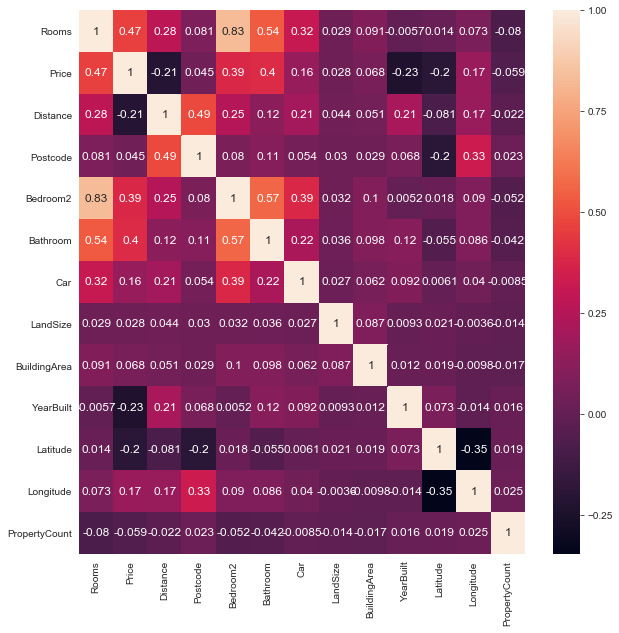

In [30]:
# Heatmap to view correlations.
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(housing.corr(), annot=True, annot_kws={'size': 12})

It seems that there are only a few variables that have decent correlations with Price (Rooms, Bathroom, and Bedroom2, possibly from Longitude and Car as well). Let's take a look at the variables in a pairplot.

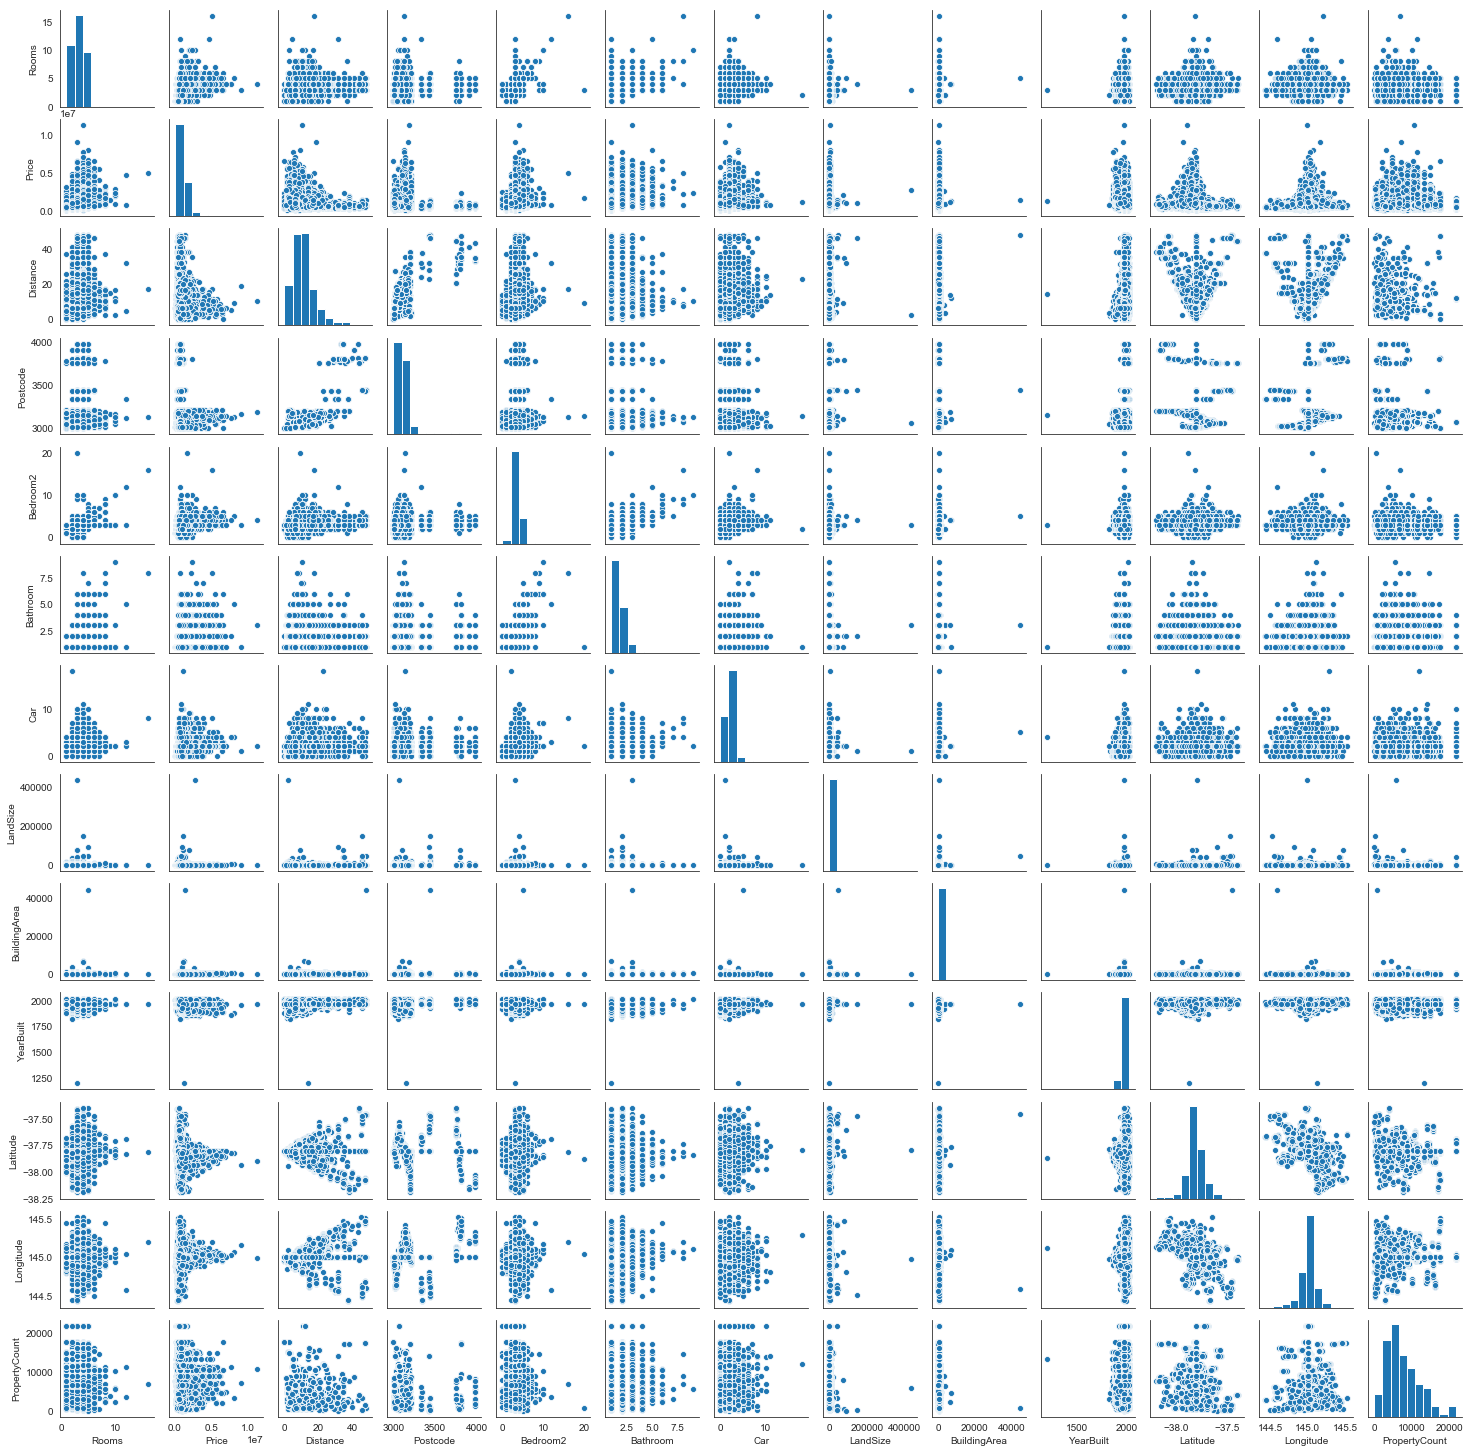

In [31]:
# Pairplot to compare variables with each other.
g = sns.pairplot(housing)
g.fig.set_size_inches(20,20)

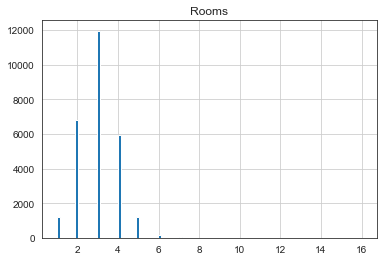

Median  3.0
Std  0.9547952950194295
Outliers above  4.909590590038859


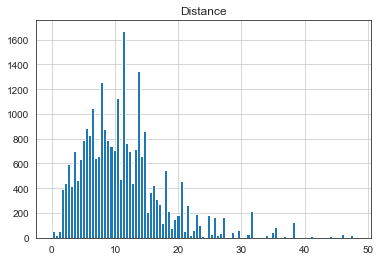

Median  10.5
Std  6.787346082260062
Outliers above  24.074692164520123


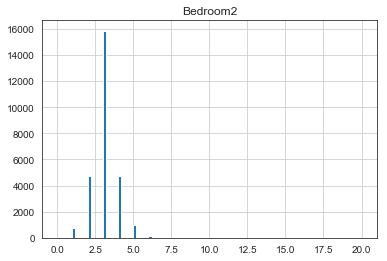

Median  3.0
Std  0.8348558728624633
Outliers above  4.669711745724927


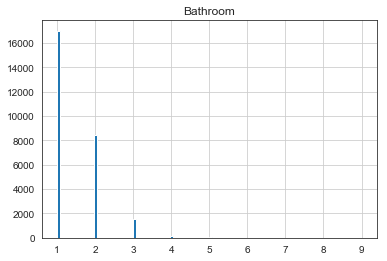

Median  1.0
Std  0.660195326204744
Outliers above  2.320390652409488


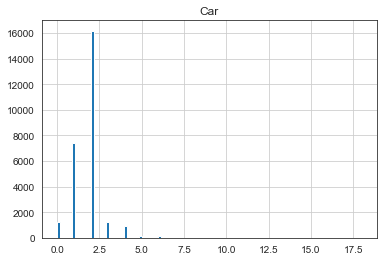

Median  2.0
Std  0.8695427951093571
Outliers above  3.739085590218714


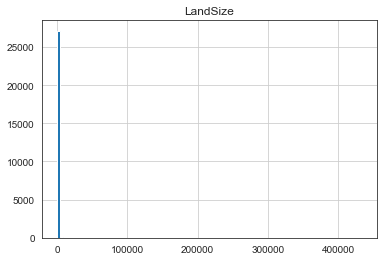

Median  512.0
Std  3052.546356726536
Outliers above  6617.092713453072


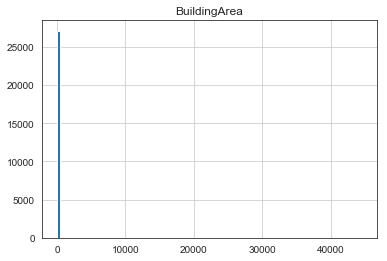

Median  133.0
Std  281.1635826376176
Outliers above  695.3271652752352


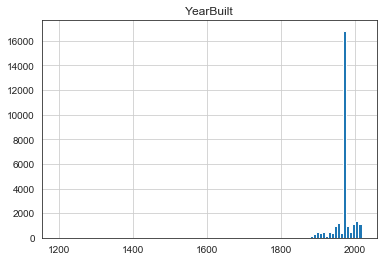

Median  1970.0
Std  24.5394765972008
Outliers below  1920.9210468055985


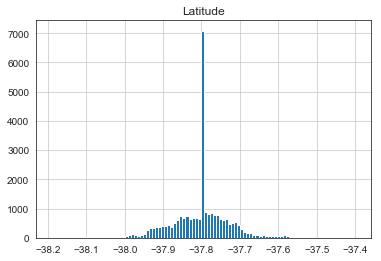

Median  -37.80046
Std  0.08046633182558413
Outliers above  -37.639527336348834
Outliers below  -37.96139266365117


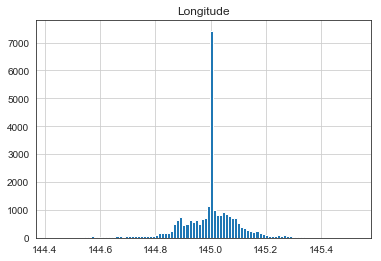

Median  145.0032
Std  0.10596341862469115
Outliers above  145.2151268372494
Outliers below  144.7912731627506


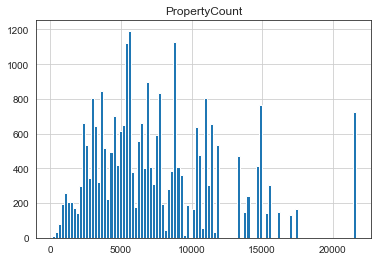

Median  6567.0
Std  4492.147336525519
Outliers above  15551.294673051038


In [32]:
# Check for outliers, central tendencies.
housing['Rooms'].hist(bins=100)
plt.title('Rooms')
plt.show()

median = housing['Rooms'].median()
std = housing['Rooms'].std()
pop_out = median + 2 * std

print('Median ', median)
print('Std ', std)
print('Outliers above ', pop_out)


housing['Distance'].hist(bins=100)
plt.title('Distance')
plt.show()

median = housing['Distance'].median()
std = housing['Distance'].std()
pop_out = median + 2 * std

print('Median ', median)
print('Std ', std)
print('Outliers above ', pop_out)


housing['Bedroom2'].hist(bins=100)
plt.title('Bedroom2')
plt.show()

median = housing['Bedroom2'].median()
std = housing['Bedroom2'].std()
pop_out = median + 2 * std

print('Median ', median)
print('Std ', std)
print('Outliers above ', pop_out)


housing['Bathroom'].hist(bins=100)
plt.title('Bathroom')
plt.show()

median = housing['Bathroom'].median()
std = housing['Bathroom'].std()
pop_out = median + 2 * std

print('Median ', median)
print('Std ', std)
print('Outliers above ', pop_out)


housing['Car'].hist(bins=100)
plt.title('Car')
plt.show()

median = housing['Car'].median()
std = housing['Car'].std()
pop_out = median + 2 * std

print('Median ', median)
print('Std ', std)
print('Outliers above ', pop_out)


housing['LandSize'].hist(bins=100)
plt.title('LandSize')
plt.show()

median = housing['LandSize'].median()
std = housing['LandSize'].std()
pop_out = median + 2 * std

print('Median ', median)
print('Std ', std)
print('Outliers above ', pop_out)


housing['BuildingArea'].hist(bins=100)
plt.title('BuildingArea')
plt.show()

median = housing['BuildingArea'].median()
std = housing['BuildingArea'].std()
pop_out = median + 2 * std

print('Median ', median)
print('Std ', std)
print('Outliers above ', pop_out)


housing['YearBuilt'].hist(bins=100)
plt.title('YearBuilt')
plt.show()

median = housing['YearBuilt'].median()
std = housing['YearBuilt'].std()
pop_out = median - 2 * std

print('Median ', median)
print('Std ', std)
print('Outliers below ', pop_out)


housing['Latitude'].hist(bins=100)
plt.title('Latitude')
plt.show()

median = housing['Latitude'].median()
std = housing['Latitude'].std()
pop_out1 = median + 2 * std
pop_out2 = median - 2 * std

print('Median ', median)
print('Std ', std)
print('Outliers above ', pop_out1)
print('Outliers below ', pop_out2)


housing['Longitude'].hist(bins=100)
plt.title('Longitude')
plt.show()

median = housing['Longitude'].median()
std = housing['Longitude'].std()
pop_out1 = median + 2 * std
pop_out2 = median - 2 * std

print('Median ', median)
print('Std ', std)
print('Outliers above ', pop_out1)
print('Outliers below ', pop_out2)


housing['PropertyCount'].hist(bins=100)
plt.title('PropertyCount')
plt.show()

median = housing['PropertyCount'].median()
std = housing['PropertyCount'].std()
pop_out = median + 2 * std

print('Median ', median)
print('Std ', std)
print('Outliers above ', pop_out)

In [33]:
# Replace outliers with pop_out value.
housing['Rooms'] = housing['Rooms'].map(lambda x: x if x < pop_out else 5)
housing['Distance'] = housing['Distance'].map(lambda x: x if x < pop_out else 25)
housing['Bedroom2'] = housing['Bedroom2'].map(lambda x: x if x < pop_out else 5)
housing['Bathroom'] = housing['Bathroom'].map(lambda x: x if x < pop_out else 3)
housing['Car'] = housing['Car'].map(lambda x: x if x < pop_out else 4)
housing['LandSize'] = housing['LandSize'].map(lambda x: x if x < pop_out else 6700)
housing['BuildingArea'] = housing['BuildingArea'].map(lambda x: x if x < pop_out else 700)
housing['YearBuilt'] = housing['YearBuilt'].map(lambda x: x if x > pop_out else 1920)
housing['Latitude'] = housing['Latitude'].map(lambda x:-37.63 if x > pop_out1 else x if 
                                              x < -37.96 else -37.97)
housing['Longitude'] = housing['Longitude'].map(lambda x: 145.22 if x > pop_out1 else x 
                                                if x > pop_out2 else 144.79)
housing['PropertyCount'] = housing['PropertyCount'].map(lambda x: x if x < pop_out else 15552)

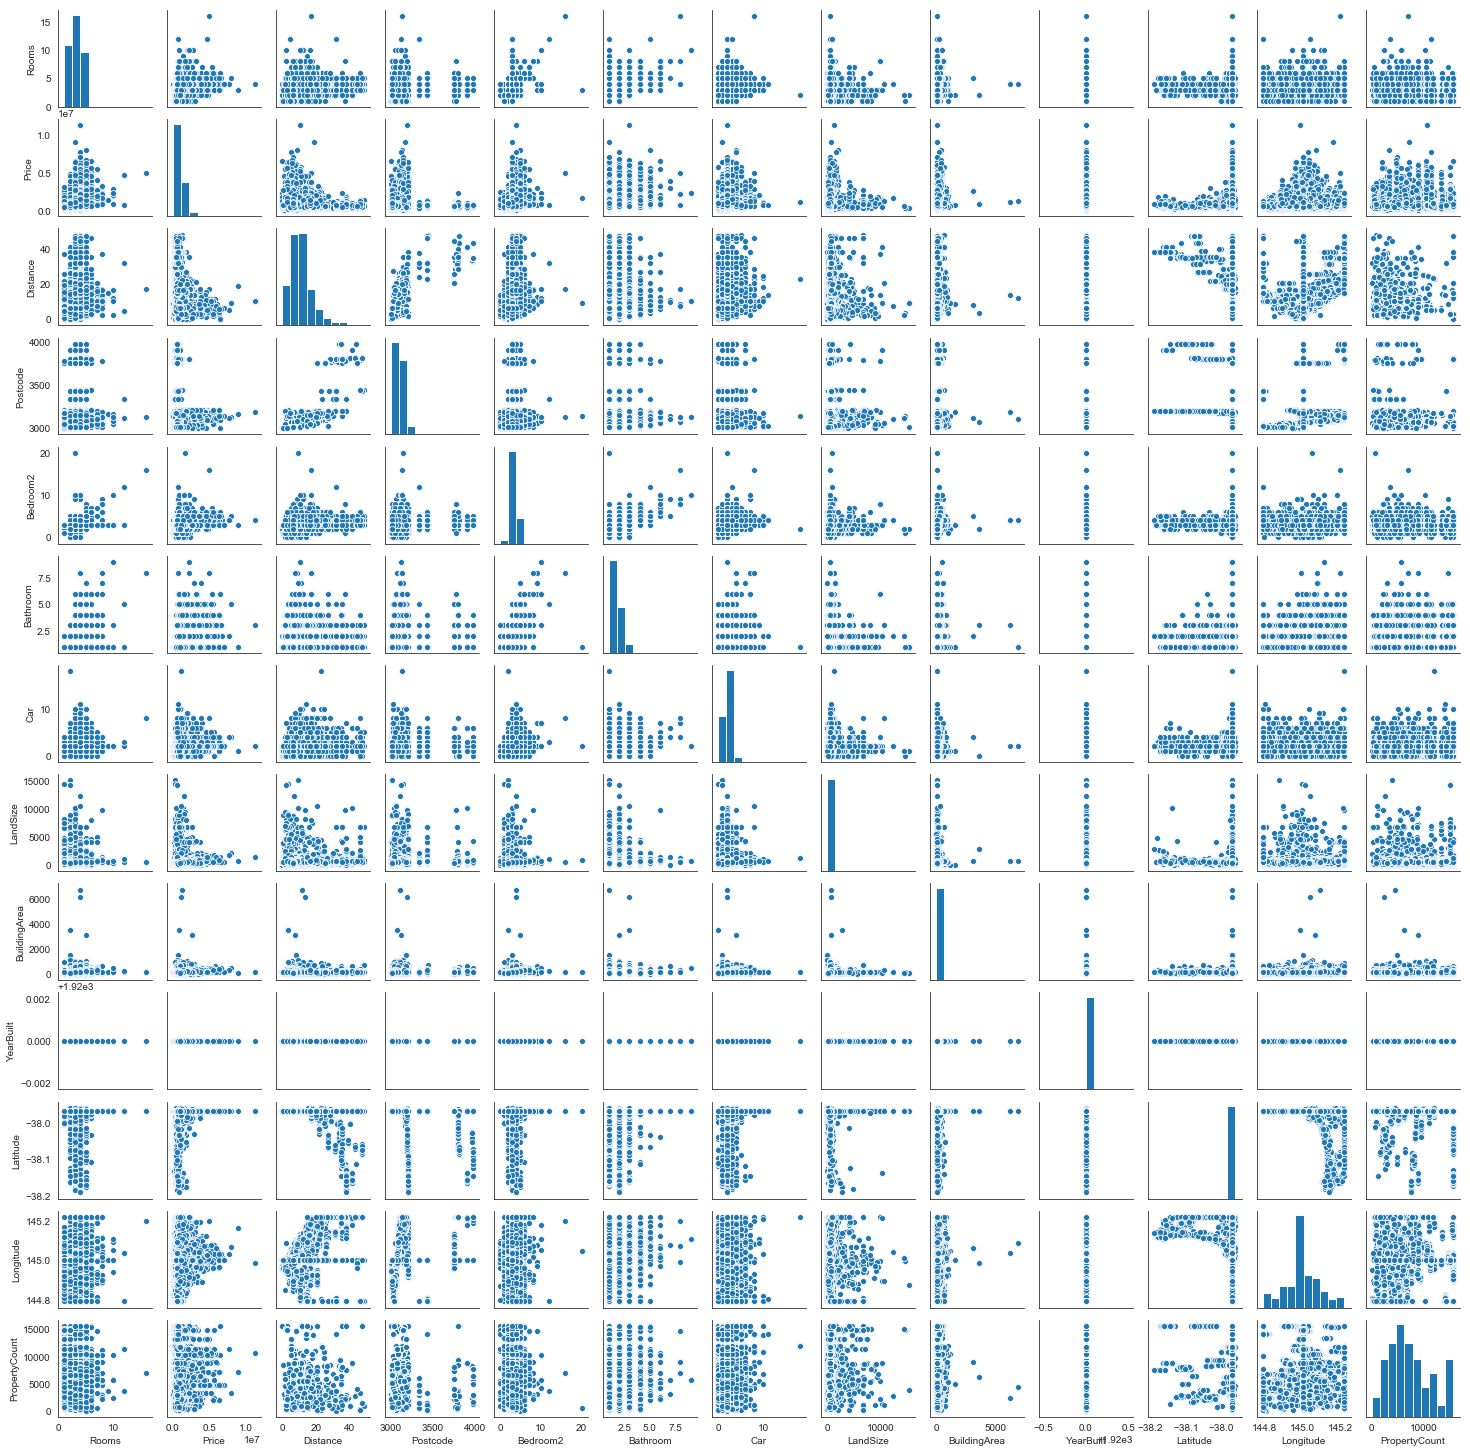

In [34]:
# Re-evaluate pairplots.
g = sns.pairplot(housing)
g.fig.set_size_inches(20,20)

We are ready to move on to models. Let's prepare our data frame for regression models.

In [35]:
housing_regr = pd.DataFrame(housing[['Rooms','Price','Distance','Postcode','Bedroom2',
                                     'Bathroom','Car','LandSize','BuildingArea','YearBuilt',
                                     'Latitude','Longitude','PropertyCount']])
housing_regr

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,LandSize,BuildingArea,YearBuilt,Latitude,Longitude,PropertyCount
1,2,1480000.000,2.500,3067.000,2.000,1.000,1.000,202.000,133.000,1920,-37.970,144.998,4019.000
2,2,1035000.000,2.500,3067.000,2.000,1.000,0.000,156.000,79.000,1920,-37.970,144.993,4019.000
4,3,1465000.000,2.500,3067.000,3.000,2.000,0.000,134.000,150.000,1920,-37.970,144.994,4019.000
5,3,850000.000,2.500,3067.000,3.000,2.000,1.000,94.000,133.000,1920,-37.970,144.997,4019.000
6,4,1600000.000,2.500,3067.000,3.000,1.000,2.000,120.000,142.000,1920,-37.970,144.994,4019.000
10,2,941000.000,2.500,3067.000,2.000,1.000,0.000,181.000,133.000,1920,-37.970,144.995,4019.000
11,3,1876000.000,2.500,3067.000,4.000,2.000,0.000,245.000,210.000,1920,-37.970,144.999,4019.000
14,2,1636000.000,2.500,3067.000,2.000,1.000,2.000,256.000,107.000,1920,-37.970,144.995,4019.000
15,3,1000000.000,2.500,3067.000,3.000,1.000,2.000,512.000,133.000,1920,-37.970,145.003,4019.000
16,2,745000.000,2.500,3067.000,3.000,1.000,2.000,512.000,133.000,1920,-37.970,145.003,4019.000


In [36]:
# Linear Regression model.
# Instantiate the regressor.
regr = linear_model.LinearRegression()
X = housing_regr[['Rooms', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom',
                  'Car', 'LandSize', 'BuildingArea', 'YearBuilt', 'Latitude',
                  'Longitude', 'PropertyCount']]
y = housing_regr['Price'].values.reshape(-1, 1)
regr.fit(X, y)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Coefficients: 
 [[ 3.68585749e+05 -4.99837052e+04  9.82039378e+02 -9.08882569e+04
   1.51066125e+05  5.20831875e+04  5.71757426e+01  5.66708306e+02
  -2.62114881e-10 -2.46605107e+06  1.11022096e+06 -4.20473438e+00]]
Intercept: 
 [-2.57285007e+08]
R-squared: 
 0.4486175479001801


ValueError: x and y must be the same size

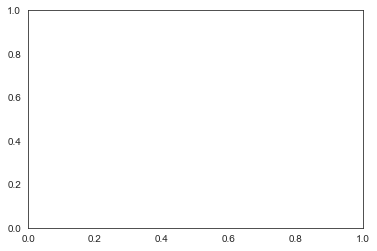

In [38]:
# Display the attributes we calculated.
print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)
print('R-squared: \n', regr.score(X, y))

# Plot outputs.
plt.scatter(X, y, color='black')
plt.plot(X, regr.predict(X), color='blue', linewidth=3)
plt.show()

In [ ]:
X

In [ ]:
y

In [ ]:
# Multivariate Regression model.


In [40]:
# K-Nearest Neighbors model.
knn = neighbors.KNeighborsRegressor(n_neighbors=5)
X = pd.DataFrame(X)
y = pd.DataFrame(y)
knn.fit(X, y)

# Set up prediction line.
T = np.arange(0, 50, 0.1)[:, np.newaxis]
y_ = knn.predict(T)

plt.scatter(X, y, c='k', label='data')
plt.plot(T, y_, c='g', label='prediction')
plt.legend()
plt.title('K=5, Unweighted')
plt.show()

ValueError: query data dimension must match training data dimension

In [ ]:
# Decision Tree model.


In [ ]:
# Random Forest model.


In [ ]:
# Support Vector Machines model.


In [ ]:
# Gradient Boosting model.


In [ ]:
# PCA model.


In [ ]:
# SelectKBest model.


linear reg
multivariate reg
knn
decision tree gridsearchcv
random forest gridsearchcv
svn
gradient boosting

pca
skbest

rsme
cross-validation
r2

no class report
no conf matrix
